<a href="https://colab.research.google.com/github/Tynk3r/CM3005-Data-Science-Coursework-1/blob/main/CM3005_Data_Science_Midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Domain-specific area and objectives of the project
The area explored in this project is that of the realm of e-commmerce, specifically regarding the sale of laptops. Understanding the factors driving prices on laptops sold on e-commerce sites will benefit both consumers and sellers, and applying a linear regression model here will help us to understand the relationship between the prices of laptops and their specifications.

The objectives of this project are as follows:


1. Choose an appropriate dataset for this project (showing both the prices and specifications of laptops on e-commerce sites).
2. Clean the dataset for missing or unclean data and preprocess it to make it easier to visualise and apply a model to.
3. Construct a predictive model that will estimate laptop prices based on the specifications of the laptop.

This accurate pricing model will help consumers by allowing them to better assess the value of a given laptop based on its specifications and this facilitate more informed purchases. It will also help sellers by letting them understand the factors affecting laptop pricing in the market, allowing them to make more strategic pricing strategies.

The significance of this project in this domain-specific area is that a more accurate model of the prices of laptops will lead to more transparent and competitive markets. It also contributes to the ongoing conversation around leveraging machine learning in e-commerce.

# 2. Dataset description

The dataset chosen for this project is a collection of laptop product listings from an e-commerce website, with its specifications and price listed. There are 1300 listings provided in the dataset, and the data types provided are as follows:
* Categorical Variables: Brand, Type, CPU, GPU, OS
* Numerical Variables: Screen Size, Resolution, RAM, Storage Capacity, Weight
* Target Variable: Price (continuous)

The source of the dataset is from Kaggle.com: https://www.kaggle.com/datasets/ehtishamsadiq/uncleaned-laptop-price-dataset


# 3. Data preparation (acquisition/cleaning/sanitisation/normalisation)

The dataset is in a CSV file format. We will first convert the dataset to a dataframe so we can perform the necessary operations on it.

The issues with the dataset, and their solutions, are as follows:
1. There are some rows with completely null data and some with ? where information was not filled in.
> We will remove these rows completely from the dataset.
2. The ScreenResolution column contains information about the screen type rather than just the resolution.
> We will remove the panel information and split it into two columns containing vertical and horizontal resolution respectively.
3. The CPU column contains inconsistently formatted data.
> We will split the CPU column into CPU Brand and Clock Speed (this is not fully accurate to real world performance but since it is for the purposes of marketing, it will be sufficient for our needs on modelling the expected price).
4. The RAM column includes units in the values.
> Remove the units from the values and rename the RAM column to RAM (GB).
4. The Memory column includes all types of storage in the system.
> We will be combining the storage capacity of all drives into the system into one column named Storage Capacity and include an additional column that contains a boolean that indicates if flash/SSDbased storage is present in the system or just spinning drives/HDDs.
5. The GPU column does not differentiate whether the GPU is the integrated GPU on the CPU or a discrete graphics card.
> We will add a column that contains a boolean indicating if the system contains a discrete graphics card or if it uses the integrated graphics.
6. The OpSys column contains inconsistently named operating systems, like macOS, Mac OS X, Windows 10, and Windows 10 S.
> Normalise all values in that column to macOS, Windows, Android, ChromeOS, Linux, or No OS. (Windows 7, 8, and 10 are folded into one as consumers will be given the prompt to upgrade to 10/11 as soon as they boot the laptop)
7. The data in the Weight column is formatted as a string with the unit (kg) included in the value.
> We will specify that the weight is in kilograms and remove the kg suffix from each value, converting them to numerical variables.
8. The price is in INR.
> We will convert this to GBP at a rate of 1 INR to 0.01 GBP.
9. One entry in the dataset has a wildly inconsistent weight to the rest of the values in the column.
> Remove this entry entirely.

In [153]:
import pandas as pd

# Convert the dataset (CSV file) to a dataframe
df = pd.read_csv('original_dataset.csv')
# Remove the index column from the CSV
df = df.drop(['Unnamed: 0'], axis=1)

### Remove all missing entries & Remove inconsistent entries.
df.replace(["0.0002kg", "?"], pd.NA, inplace=True) # Missing entries have ? in that cell. This line changes those to null so dropna() will catch and remove them. (Also 0.0002kg is the only inconsistent entry in the dataset not set to a ?)
df = df.dropna()
###

### Remove extraneous information from the ScreenResolution column
# set a regex to match resolution format and extract it from the ScreenResolution column
resolution_pattern = r'(\d+)x(\d+)'
resolutions = df['ScreenResolution'].str.extract(resolution_pattern)
# insert the two new columns
df.insert(df.columns.get_loc('ScreenResolution') + 1, 'HorizontalResolution', resolutions[0])
df.insert(df.columns.get_loc('ScreenResolution') + 2, 'VerticalResolution', resolutions[1])
# clean up and convert values to numerical (use .loc because setting value throws warning)
df.loc[:, ['HorizontalResolution', 'VerticalResolution']] = df[['HorizontalResolution', 'VerticalResolution']].astype(float)
df = df.drop('ScreenResolution', axis=1)
###

### Split CPU information
# extract clock speed using a regex then remove it from the original value
clock_speed_pattern = r'(\d+(\.\d+)?)GHz'
clock_speeds = df['Cpu'].str.extract(clock_speed_pattern)
df.insert(df.columns.get_loc('Cpu') + 1, 'Clock Speed (GHz)', clock_speeds[0])
df.loc[:, ['Clock Speed (GHz)']] = df[['Clock Speed (GHz)']].astype(float) # set as float
df['Cpu'] = df['Cpu'].str.replace(clock_speed_pattern, '')
# extract the cpu brand using a regex then replace the original column with the CPU Brand column
cpu_brand_pattern = r'^(Intel|AMD|Samsung)'
cpu_brands = df['Cpu'].str.extract(cpu_brand_pattern)
df.insert(df.columns.get_loc('Cpu') + 1, 'CPU Brand', cpu_brands)
df = df.drop('Cpu', axis=1)
###

### Remove unit from RAM column
ram_pattern = r'(\d+)GB'
ram_values = df['Ram'].str.extract(ram_pattern)
df.insert(df.columns.get_loc('Ram') + 1, 'RAM (GB)', ram_values[0])
df.loc[:, ['RAM (GB)']] = df[['RAM (GB)']].astype(int)
df = df.drop(['Ram'], axis=1)
###

### Combine storage capacity and add column for if only HDD storage is used
# Extract GB and TB capacities into two temp columns, then combine into Total Storage (GB) and delete temp columns
def extract_storage_capacity(memory_str, unit='GB'):
    pattern = r'(\d+(\.\d+)?)\s?(?:' + unit + ')'
    capacities = df[memory_str].str.extractall(pattern)[0].astype(float)
    return capacities.groupby(level=0).sum()
df['tempGB'] = extract_storage_capacity('Memory', 'GB')
df['tempTB'] = extract_storage_capacity('Memory', 'TB') * 1024
df.insert(df.columns.get_loc('Memory') + 1, 'Total Storage (GB)', df['tempGB'].fillna(0) + df['tempTB'].fillna(0))
df['Total Storage (GB)'] = df['Total Storage (GB)'].astype(int)
df = df.drop(['tempGB', 'tempTB'], axis=1)
# Check if flash memory is present
storage_pattern = r'HDD'
df.insert(df.columns.get_loc('Memory') + 2, 'HDD Only?', df['Memory'].str.contains(storage_pattern, case=False))
df['HDD Only?'] = df['HDD Only?'].astype(int)
# Get rid of the memory column since we dont need it anymore
df = df.drop(['Memory'], axis=1)
###

### Display column that indicates if integrated or discrete graphics
discrete_graphics_pattern = r'Nvidia|AMD Radeon|AMD FirePro'
df.insert(df.columns.get_loc('Gpu') + 1, 'Discrete Graphics?', df['Gpu'].str.contains(discrete_graphics_pattern, case=True))
df['Discrete Graphics?'] = df['Discrete Graphics?'].astype(int)
###

### Normalise OS values
os_mapping = {
    'Mac OS X': 'macOS',
    'macOS': 'macOS',
    'Windows 10': 'Windows',
    'Windows 10 S': 'Windows',
    'Windows 7': 'Windows',
    'Linux': 'Linux',
    'Android': 'Android',
    'Chrome OS': 'ChromeOS'
}
df['OpSys'] = df['OpSys'].map(os_mapping).fillna('No OS')
###

### Remove unit from weight column
weight_pattern = r'(\d+(\.\d+)?)kg'
weights = df['Weight'].str.extract(weight_pattern)
df.insert(df.columns.get_loc('Weight') + 1, 'Weight (kg)', weights[0])
df.loc[:, ['Weight (kg)']] = df[['Weight (kg)']].astype(float)
df = df.drop(['Weight'], axis=1)
###

### Convert price to GBP
df.insert(df.columns.get_loc('Price') + 1, 'Price (GBP)', (df['Price'] * 0.01).round(2))
df.loc[:, ['Price (GBP)']] = df[['Price (GBP)']].astype(float)
df = df.drop(['Price'], axis=1)
###

# Drop the original 'Price' column if needed
# df = df.drop(['Price'], axis=1)
###

# Save the cleaned dataframe to file
df.to_csv('cleaned_dataset.csv', index=False)

<ipython-input-153-7903b4e3e97c>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, ['HorizontalResolution', 'VerticalResolution']] = df[['HorizontalResolution', 'VerticalResolution']].astype(float)
<ipython-input-153-7903b4e3e97c>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, ['Clock Speed (GHz)']] = df[['Clock Speed (GHz)']].astype(float) # set as float
<ipython-input-153-7903b4e3e97c>:31: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cpu'] = df['Cpu'].str.replac

# 4. Statistical analysis
We will now perform a summmary of the dataset.



We will start by importing the necessary python libraries.

In [154]:
import pandas as pd
from scipy.stats import describe

We will then load the cleaned dataset from the previous section as a dataframe, as before.

In [155]:
df = pd.read_csv('cleaned_dataset.csv')

## 4.1 Statistical Summary of Numerical Variables
We will now provide a summary of the numerical variables in the dataset, namely the screen size, resolution, memory, storage capacity, weight, and price. As is common for consumer electronics, the budget or lower end systems are overrepresented, with a fewer amount of higher end configurations being available for purchase.

In [156]:
print(df.describe())

            Inches  HorizontalResolution  VerticalResolution  \
count  1269.000000           1269.000000         1269.000000   
mean     15.131521           1894.138692         1070.509062   
std       1.955982            494.972331          284.848218   
min      10.100000           1366.000000          768.000000   
25%      14.000000           1600.000000          900.000000   
50%      15.600000           1920.000000         1080.000000   
75%      15.600000           1920.000000         1080.000000   
max      35.600000           3840.000000         2160.000000   

       Clock Speed (GHz)     RAM (GB)  Total Storage (GB)    HDD Only?  \
count        1269.000000  1269.000000         1269.000000  1269.000000   
mean            2.299149     8.457841          621.784082     0.443656   
std             0.507024     5.569109          481.350565     0.497011   
min             0.900000     1.000000            8.000000     0.000000   
25%             2.000000     4.000000          256.00

## 4.2 Statistical Summary of Categorical Variables
Looking at the summary of the categorical variables in the dataset, namely the brand, system type, CPU brand, GPU, and operating system, we can make quite a few observations. Not many manufacturers actually are in the laptop ecommerce market, with only 19 different manufacturers being included in the dataset. Lenovo is by and far the largest manufacturer of laptops sold on this site, accounting for over 20% of systems listed. Despite the wide variety of laptop style systems being sold, regular notebooks were the most listed. Additionally, Intel CPUs were most common among systems, and their integrated graphics solutions were also the most common. 75% of systems listed also had Windows pre installed as an operating system, though many more were listed as No OS and would likely include a free install of Windows, as is common on many ecommerce sites.

In [157]:
print(df.describe(include=['object']))

       Company  TypeName CPU Brand                    Gpu    OpSys
count     1269      1269      1269                   1269     1269
unique      19         6         3                    110        6
top     Lenovo  Notebook     Intel  Intel HD Graphics 620  Windows
freq       290       709      1206                    271     1096


## 4.3 Type of Distribution of Key Series
Seeing as our project sets out to model the price of a laptop based on its specifications, our key series to analyse is price. To analyse the type of distribution for the price column, we will visualise the data using a histogram.

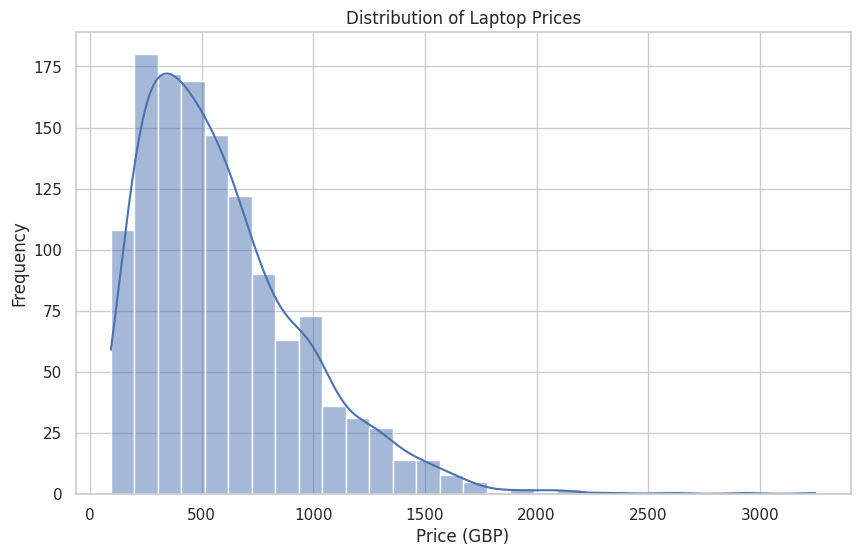

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.title('Distribution of Laptop Prices')
plt.xlabel('Price (GBP)')
plt.ylabel('Frequency')

sns.histplot(df['Price (GBP)'], bins=30, kde=True)

plt.show()


We can see that the distribution is right or positively skewed, since as is normal for consumer electronics, there are many more players in the budget space, leading to an overrepresentation on ecommerce websites as compared to the relatively sparse choice in the higher end of the market.

# 5. Visualisation

We will be visualising a few data series, namely:
- The relationship between the CPU brand and its price
- The relationship between whether a laptop has discrete graphics and its price
- The relationship between the total storage and price
- The relationship between whether a laptop has discrete graphics and its screen size
- The relationship between the screen size and weight

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

## Price vs CPU Brand
We will use a box plot to visualise the relationship between a laptop's CPU brand versus its price.

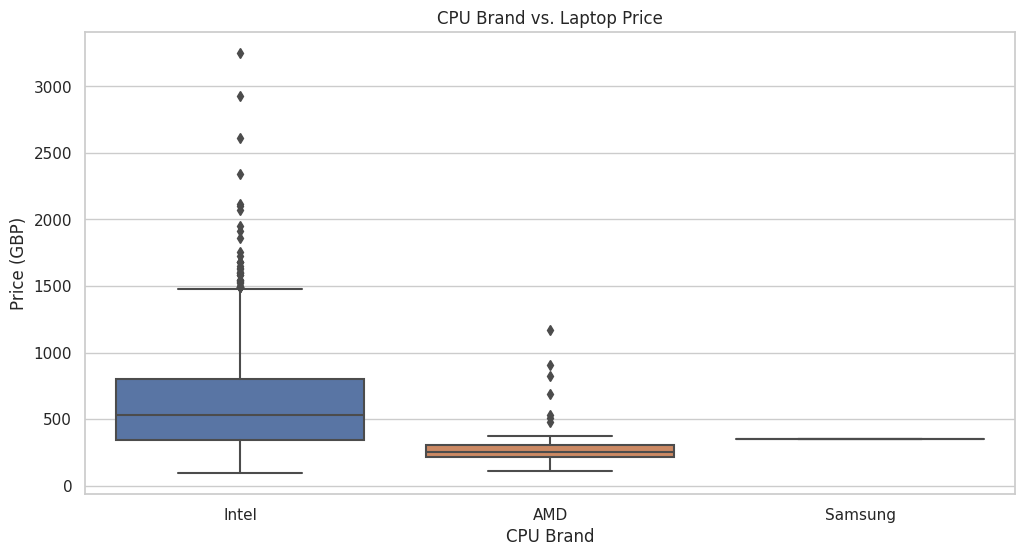

In [160]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='CPU Brand', y='Price (GBP)', data=df)
plt.title('CPU Brand vs. Laptop Price')
plt.xlabel('CPU Brand')
plt.ylabel('Price (GBP)')
plt.show()

Since Intel is by and large the largest manufacturer of CPUs for laptops, the results that show it is represented at every price range is not surprising. However, AMD CPUs seem to mostly reside in lower spec systems, which indicates that AMD is targeting the larger demand for budget laptops.

## Price vs Discrete Graphics
We will use a box plot to visualise the relationship between whether a laptop has discrete graphics versus its price.

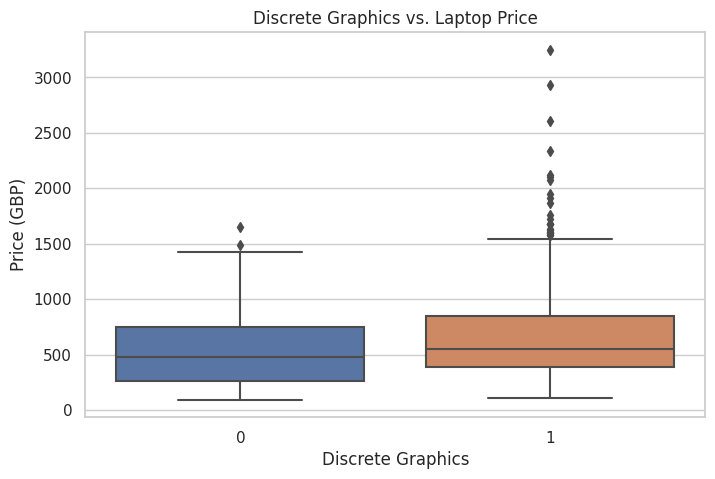

In [161]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Discrete Graphics?', y='Price (GBP)', data=df)
plt.title('Discrete Graphics vs. Laptop Price')
plt.xlabel('Discrete Graphics')
plt.ylabel('Price (GBP)')
plt.show()

Although the results that higher priced laptops are more likely to include a discrete graphics processor is unsurprising, the small price gap is unexpected. The price distribution of laptops with discrete graphics processors is only a few hundred GBP in difference from those without, showing us that even budget laptops nowadays will usually include some sort of discrete graphics solution, and allows us to draw the conclusion that even at lower prices, consumers will not settle for a laptop without discrete graphics.

## Price vs Storage
We will use a scatter plot to visualise the relationship between a laptop's total storage capacity versus its price.

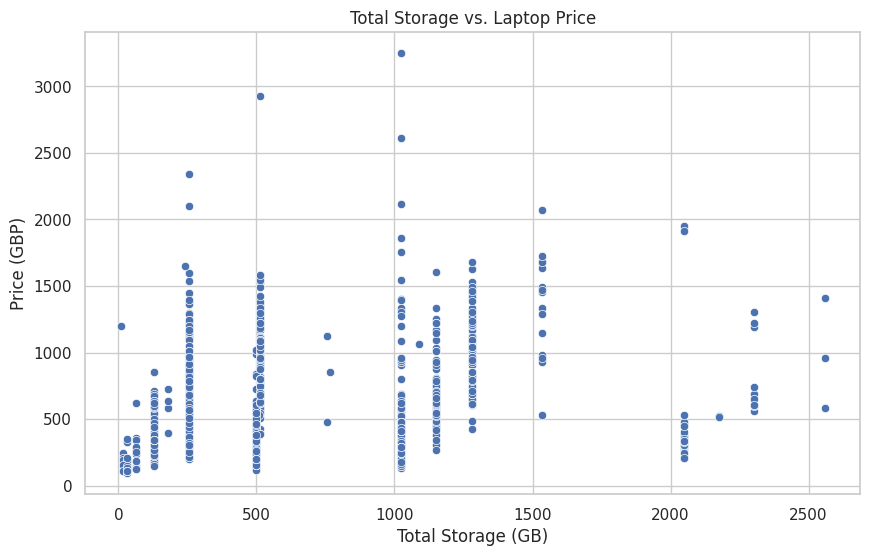

In [162]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total Storage (GB)', y='Price (GBP)', data=df)
plt.title('Total Storage vs. Laptop Price')
plt.xlabel('Total Storage (GB)')
plt.ylabel('Price (GBP)')
plt.show()

Surprisingly, the highest storage capacity laptops are not also the highest priced ones - many of them sit in the mid-range, with many in the budget range in this dataset. The highest priced laptops have a variety of storage capacities ranging from under 500GB to over 1.5TB. Although the data we have is not enough to draw a conclusion as to why this is the case, one theory is that the users of higher end laptops - often video editors, graphic designers, 3D artists, or workers who have need of both portability and high performance - often have network storage solutions and thus do not need the extra weight and price of a large internal storage capacity.

## Discrete Graphics vs Screen Size
Moving away from price, we will now use a box plot to visualise the relationship between a laptop's screen size and whether it includes discrete graphics.

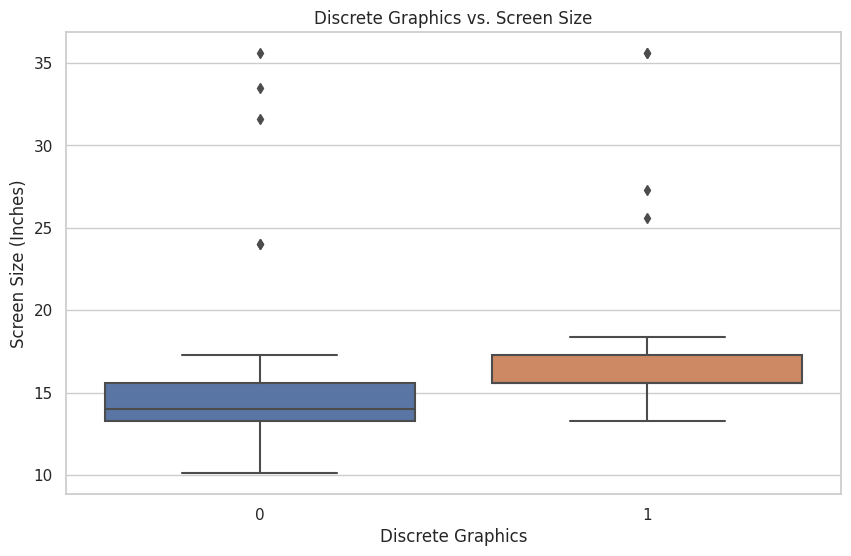

In [163]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Discrete Graphics?', y='Inches', data=df)
plt.title('Discrete Graphics vs. Screen Size')
plt.xlabel('Discrete Graphics')
plt.ylabel('Screen Size (Inches)')
plt.show()

As expected, larger screen sizes tend to correspond with the presence of discrete graphics on a system. Discrete graphics usually indicates a user that intends to use their system for gaming or for heavy work as opposed to just for casual or office use, which makes sense why those users would want more screen real estate to perform their tasks.

## Screen Size vs Weight
Finally, we will use a scatter plot to visualise the relationship between a laptop's screen size and its weight.

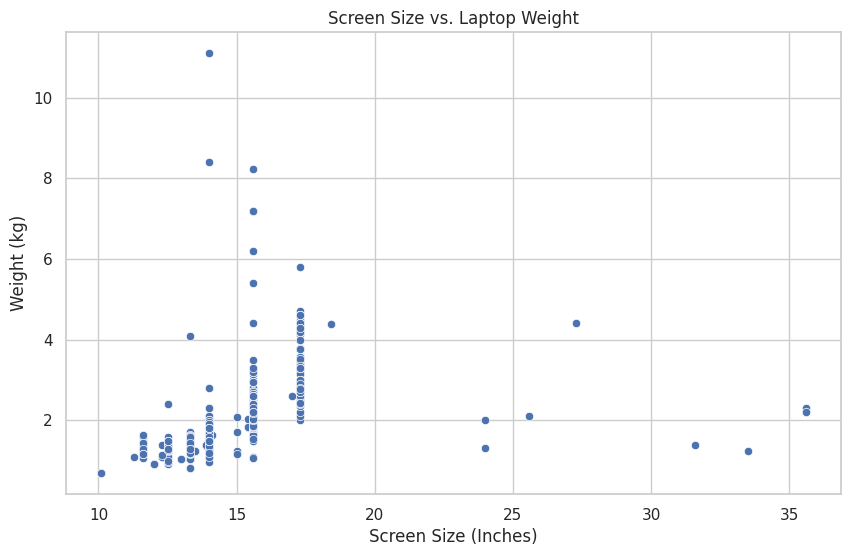

In [164]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Inches', y='Weight (kg)', data=df)
plt.title('Screen Size vs. Laptop Weight')
plt.xlabel('Screen Size (Inches)')
plt.ylabel('Weight (kg)')
plt.show()

While the majority of systems listed in this data set follow the trend of larger screen sizes corresponding to a heavier weight, it is nonetheless interesting to note that the heaviest laptop has a screen size of below 15 inches, and the biggest screen size laptop with over 35 inches of screen size is relatively svelte, coming in at just over 2kg.

# 6. Building the model

We will start by importing the necessary libraries and loading the cleaned dataset into a dataframe.

In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("cleaned_dataset.csv")
df.head()

,Company,TypeName,Inches,HorizontalResolution,VerticalResolution,CPU Brand,Clock Speed (GHz),RAM (GB),Total Storage (GB),HDD Only?,Gpu,Discrete Graphics?,OpSys,Weight (kg),Price (GBP)
0,Apple,Ultrabook,13.3,2560.0,1600.0,Intel,2.3,8,128,0,Intel Iris Plus Graphics 640,0,macOS,1.37,713.79
1,Apple,Ultrabook,13.3,1440.0,900.0,Intel,1.8,8,128,0,Intel HD Graphics 6000,0,macOS,1.34,478.96
2,HP,Notebook,15.6,1920.0,1080.0,Intel,2.5,8,256,0,Intel HD Graphics 620,0,No OS,1.86,306.36
3,Apple,Ultrabook,15.4,2880.0,1800.0,Intel,2.7,16,512,0,AMD Radeon Pro 455,1,macOS,1.83,1351.95
4,Apple,Ultrabook,13.3,2560.0,1600.0,Intel,3.1,8,256,0,Intel Iris Plus Graphics 650,0,macOS,1.37,960.96


## Feature & Label Selection
Since this project aims to model the expected price of a laptop based on its specifications, we will use the price in GBP as its label. The features we will use to predict the price are the variables RAM (GB), Discrete Graphics?, Weight (kg), HDD Only?, and Clock Speed (GHz). We chose these values as they seem to be the ones power users, or those who would buy a higher priced laptop, would go for in a laptop.

In [166]:
features = df[['Clock Speed (GHz)', 'RAM (GB)', 'HDD Only?', 'Discrete Graphics?', 'Weight (kg)']]
label = df['Price (GBP)']

## Split Dataset into Training and Testing Sets
We will use sckitlearn to build this model. First, we split the dataset into two parts, one to train the model, and one to later evaluate the model's functionality. The code below splits it into 80% for training and 20% for testing.

In [167]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

## Building and Training the Model
We will now create and train the model using the training data created in the previous step.

In [168]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Evaluation of the Model
We will use the now-trained model to make predictions on the test set, and evaluate its performance.

In [169]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 44731.931628642276
R-squared: 0.5683071235462527


The MSE of this model is extremely high, and indicates that there is a low chance of predicting the correct price based on the specifications. However, the R-squared, while not perfect, is a decent start, indicating that the variables we have chosen is not far off from being able to make an accurate prediction of the prices.

# 7. Validation
In this section, we will explore methods of validating the above model's results.

## Cross Validation
We will implement cross-validation using scikit-learn. This will evaluate the generalizability of the model above on new, unseen data.

In [170]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(model, features, label, cv=5, scoring='neg_mean_squared_error')
cross_val_mse = -cross_val_scores
average_mse = cross_val_mse.mean()

print(f'Average Cross-Validated Mean Squared Error: {average_mse}')

Average Cross-Validated Mean Squared Error: 65030.18946616093


Since the cross-validated MSE is significantly higher, we can draw the conclusion that the generalizability of this model is low, and it will not perform well on new, unseen data.

## Random Forest Regressor

We will also try a validation method called the Random Forest Regressor, that uses multiple independent decision trees all trained on random subsets of the dataset, and averages the result, resulting in reduced overfitting.

In [171]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f'Random Forest Mean Squared Error: {rf_mse}')
print(f'Random Forest R-squared: {rf_r2}')

Random Forest Mean Squared Error: 30103.273332550638
Random Forest R-squared: 0.7094834007284159


The implementation of the Random Forest model has significantly improved over the original Linear Regression model, with an MSE of 30103 compared to 44731 and an R-squared of 0.7 vs 0.56. We can draw the conclusion that this particular dataset lends itself better to the Random Forest Regressor model, since we observed a ~20% improvement in both metrics.

# 8. Feature Engineering
We will now implement feature engineering techniques, and revaluate the model's performance.

In [173]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("cleaned_dataset.csv")
df.head()

,Company,TypeName,Inches,HorizontalResolution,VerticalResolution,CPU Brand,Clock Speed (GHz),RAM (GB),Total Storage (GB),HDD Only?,Gpu,Discrete Graphics?,OpSys,Weight (kg),Price (GBP)
0,Apple,Ultrabook,13.3,2560.0,1600.0,Intel,2.3,8,128,0,Intel Iris Plus Graphics 640,0,macOS,1.37,713.79
1,Apple,Ultrabook,13.3,1440.0,900.0,Intel,1.8,8,128,0,Intel HD Graphics 6000,0,macOS,1.34,478.96
2,HP,Notebook,15.6,1920.0,1080.0,Intel,2.5,8,256,0,Intel HD Graphics 620,0,No OS,1.86,306.36
3,Apple,Ultrabook,15.4,2880.0,1800.0,Intel,2.7,16,512,0,AMD Radeon Pro 455,1,macOS,1.83,1351.95
4,Apple,Ultrabook,13.3,2560.0,1600.0,Intel,3.1,8,256,0,Intel Iris Plus Graphics 650,0,macOS,1.37,960.96


We will implement a polynomial regression model instead of a linear regression model, with the same parameters.

In [180]:
features = df[['Clock Speed (GHz)', 'RAM (GB)', 'HDD Only?', 'Discrete Graphics?', 'Weight (kg)']]
label = df['Price (GBP)']
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(X_train, y_train)

# prediction
y_pred_poly = polyreg.predict(X_test)

# evaluation
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f'Mean Squared Error (Polynomial): {mse_poly}')
print(f'R-squared (Polynomial): {r2_poly}')


Mean Squared Error (Polynomial): 39204.36273050357
R-squared (Polynomial): 0.6216518379494611


As shown above, a polynomial regression with a degree of 2 shows an improvement over the linear regression model used previously, though still underperforming compared to the random forest regressor. We still saw about a 10% improvement over the standard linear regression, which demonstrates how polynomial regression may be better suited to this dataset that linear.

# 10. Evaluation of Models
We will first numerically evaluate the results of the three models used above to model the prices of laptops on the ecommerce site based on their specifications. We use RMSE as a metric due to it showing the relative performance of each model to each other, with a lower RMSE being better.

In [181]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate Linear Regression model
linear_regression_rmse = np.sqrt(mse)
print(f"Linear Regression RMSE: {linear_regression_rmse}")
print(f"Linear Regression R-squared: {r2}")

# Evaluate Random Forest Regressor model
random_forest_rmse = np.sqrt(rf_mse)
print(f"Random Forest RMSE: {random_forest_rmse}")
print(f"Random Forest R-squared: {rf_r2}")

# Evaluate Polynomial Regression model
polynomial_regression_rmse = np.sqrt(mse_poly)
print(f"Polynomial Regression RMSE: {polynomial_regression_rmse}")
print(f"Polynomial Regression R-squared: {r2_poly}")


Linear Regression RMSE: 211.4992473476969
Linear Regression R-squared: 0.5683071235462527
Random Forest RMSE: 173.50294906009708
Random Forest R-squared: 0.7094834007284159
Polynomial Regression RMSE: 198.00091598400138
Polynomial Regression R-squared: 0.6216518379494611


Out of the three models built for this dataset, the Random Forest is objectively the best performer, with the lowest RMSE out of the three. This project set out to provide an accurate prediction of price based on a given laptop's specifications, and although the models built ultimately did not produce an accurate enough prediction to be able to be used by every consumer, we believe that this model can be improved enough with more data and better training methods, as proven by the significant improvement by using a different model. This process is also highly transferable to any other dataset, as these tools only rely on a clean dataset and the various models and visualisation techinques could easily be adapted to work on different types of data. Overall, this project lays the groundwork for future advancements in using machine learning to improve ecommerce markets and serves as a template for applying similar methodologies to other domain-specific areas.